# **Multiclass Sentiment Prediction Modelss** -- CONTINUES

This notebook is the continuation of notebook 04b.
We use this new notebook because the following model needs specific libraries versions to run.

## **2. Install necessary packages and libraries**

In [1]:
!pip install tensorflow==2.15.0 --quiet
!pip install tf_keras==2.15.0 --quiet
!pip install transformers==4.17 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.69 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.8 MB/s eta 0:00:

In [2]:
def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [3]:
#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')

numpy version: 1.26.4
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
# import tensorflow_datasets as tfds
# import tensorflow_text as tf_text
import transformers

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from sklearn.model_selection import train_test_split

from sklearn import model_selection


## 3. **Load the dataset**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

CSV_path = '/content/drive/MyDrive/NLP/combined_VERY_VERY_FINAL.csv'
df = pd.read_csv(CSV_path)
df.head()

Mounted at /content/drive


,news_org,title,summary,total_reactions,article_screenshot_s3_link,reactions_screenshot_s3_link,article_sc_date,reactions_sc_date,total_comments,total_shares,...,ratio_angry,ratio_care,cleaned_title,cleaned_summary,vader_sentiment_score,embedding,vader_sentiment_class,sentiment_score,headline_sentiment_class,news_label
0,The_Wall_Street_Journal,Would You Zap Yourself With Electricity to Get...,One of the latest trends in boutique fitness i...,27,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:07:51,2024-10-14 16:07:55,4,3,...,0.037037,0.000000,would zap electricity get shape,one late trend boutique fitness electrify lite...,-0.1027,[-9.65170786e-02 -6.67401850e-02 2.26862580e-...,1,-0.011845,1,0
1,The_Wall_Street_Journal,Tesla Considers $775 Million Texas Factory Exp...,Tesla is considering more than $775 million in...,108,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:00,2024-10-14 16:08:05,15,3,...,0.009259,0.009259,tesla considers million texas factory expansion,tesla consider million expansion electricvehic...,-0.4215,[-3.15038592e-01 8.39137062e-02 2.63236046e-...,1,0.005470,2,1
2,The_Wall_Street_Journal,Steven Spielberg’s ‘The Fabelmans’ Wins Best D...,"“The Fabelmans,” Steven Spielberg’s tale of a ...",184,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:24,2024-10-14 16:08:28,83,4,...,0.005435,0.010870,steven spielberg fabelmans win best drama,fabelmans steven spielberg tale childhood indo...,0.8402,[-5.72552562e-01 1.90420046e-01 2.98330992e-...,3,0.012617,2,1
3,The_Wall_Street_Journal,Abbott Elementary' Is a Golden Globes Favorite,Abbott Elementary' won three awards at the Gol...,273,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:33,2024-10-14 16:08:38,38,6,...,0.003663,0.007326,abbott elementary golden globe favorite,abbott elementary three award golden globe inc...,0.4588,[-6.08102679e-01 -1.03185527e-01 1.87640250e-...,2,0.093773,2,1
4,The_Wall_Street_Journal,An Absent Cate Blanchett Wins Best Actress in ...,Cate Blanchett proved herself a movie maestro ...,263,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:45,2024-10-14 16:08:53,7,10,...,0.003802,0.007605,absent cate blanchett win best actress motion ...,cate blanchett prove movie maestro tr earn bes...,0.8402,[-7.72164404e-01 1.47608727e-01 -2.20909327e-...,3,0.063339,2,1


## **4. Data Preparation**

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Assuming your DataFrame is named 'df'
# Separate features (headlines) and labels (sentiment classes)
X = df['title']
y = df['headline_sentiment_class']

# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
X_train_resampled = pd.Series(X_train_resampled.flatten())
X_train = X_train_resampled
y_train = y_train_resampled # Update y_train with resampled labels

# Now you have X_train, y_train, X_val, y_val, X_test, and y_test
# with balanced classes and the desired split
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (5992,), (5992,)
Validation data shape: (1324,), (1324,)
Testing data shape: (1325,), (1325,)


## **5. Modeling Using BERT + CNN**

In [7]:
from transformers import BertTokenizer, TFBertModel

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Function to tokenize data
def tokenize_data(texts, max_len):
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    return inputs

# Define max sequence length
MAX_SEQUENCE_LENGTH = 128

# Tokenize training, validation, and test data
X_train_tokens = tokenize_data(X_train, MAX_SEQUENCE_LENGTH)
X_val_tokens = tokenize_data(X_val, MAX_SEQUENCE_LENGTH)
X_test_tokens = tokenize_data(X_test, MAX_SEQUENCE_LENGTH)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [10]:
# Create CNN-on-BERT model
def create_bert_cnn_model(bert_cnn_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters=[131, 127, 51, 23, 17],
                          kernel_sizes=[2, 3, 4, 5, 7],
                          dropout=0.5,
                          hidden_size=275,
                          learning_rate=0.00005,
                          # learning_rate=0.0005,
                          num_classes=4):
    """
    Build a classification model with BERT, applying CNN layers to the BERT output.
    """
    # Make the BERT model fully trainable
    bert_cnn_model.trainable = True

    # Define the inputs for the model
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask_layer')

    # Prepare the inputs in a dictionary format
    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }

    # Obtain the outputs from the BERT model
    bert_outputs = bert_cnn_model(bert_inputs)

    # Get the sequence output from BERT
    sequence_output = bert_outputs.last_hidden_state

    # Apply CNN layers to the sequence_output
    conv_layers = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='valid'
        )(sequence_output)
        # Apply Global Max Pooling
        pooled_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers.append(pooled_layer)

    # Concatenate the outputs from all convolutional layers
    cnn_output = tf.keras.layers.Concatenate()(conv_layers)

    # Apply dropout for regularization
    dropout_layer = tf.keras.layers.Dropout(rate=dropout)(cnn_output)

    # Add a hidden dense layer with ReLU activation
    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(dropout_layer)

    # Apply another dropout layer (optional)
    hidden_layer = tf.keras.layers.Dropout(rate=dropout)(hidden_layer)

    # Final classification layer with sigmoid activation (binary classification)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden_layer)

    # Build the classification model
    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=output_layer
    )

    # Compile the model with Adam optimizer, binary crossentropy loss, and accuracy as the metric
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        # Use SparseCategoricalCrossentropy instead of SparseCategoricalCrossentropyCrossentropy
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return classification_model

In [11]:
for layer in bert_model.layers:
    if 'pooler' in layer.name:
        layer.trainable = False

# Instantiate the model
classification_model = create_bert_cnn_model(bert_model, max_sequence_length=MAX_SEQUENCE_LENGTH)

# Train the model
history = classification_model.fit(
    [X_train_tokens['input_ids'],
     X_train_tokens['token_type_ids'],
     X_train_tokens['attention_mask']],
    y_train,
    validation_data=(
        [X_val_tokens['input_ids'],
         X_val_tokens['token_type_ids'],
         X_val_tokens['attention_mask']],
        y_val
    ),
    epochs=5,
    batch_size=32
)

Epoch 1/5


188/188 [==============================] - 128s 438ms/step - loss: 1.2597 - accuracy: 0.4297 - val_loss: 1.1449 - val_accuracy: 0.4554
Epoch 2/5
188/188 [==============================] - 78s 413ms/step - loss: 0.7631 - accuracy: 0.6677 - val_loss: 1.1100 - val_accuracy: 0.5189
Epoch 3/5
188/188 [==============================] - 78s 413ms/step - loss: 0.5587 - accuracy: 0.7717 - val_loss: 1.0418 - val_accuracy: 0.5665
Epoch 4/5
188/188 [==============================] - 78s 413ms/step - loss: 0.3831 - accuracy: 0.8511 - val_loss: 1.1622 - val_accuracy: 0.5657
Epoch 5/5
188/188 [==============================] - 78s 414ms/step - loss: 0.2544 - accuracy: 0.9132 - val_loss: 1.3436 - val_accuracy: 0.5650


---- end of bert+cnn

In [17]:
# Save the trained BERT model
# classification_model.save('/content/drive/MyDrive/NLP/BERT_CNN_Multi_tokenizer4C') # used this first
# Save the model to a file with the '.keras' extension (recommended)
classification_model.save(
    '/content/drive/MyDrive/NLP/BERT_CNN_Multi_tokenizer4C/model.keras'
)

In [19]:
classification_model.save(
    '/content/drive/MyDrive/NLP/BERT_CNN_Multi_tokenizer4C/model.h5'
)

In [20]:
from transformers import TFBertModel

classification_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/NLP/BERT_CNN_Multi_tokenizer4C/model.h5',
    custom_objects={'TFBertModel': TFBertModel}
)

### **5.1 Model Testing**

In [21]:
# Evaluate the model on the test set
loss, accuracy = classification_model.evaluate(
    [X_test_tokens['input_ids'], X_test_tokens['token_type_ids'], X_test_tokens['attention_mask']],
    y_test,
    verbose=0
)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# Make predictions on the test set
y_pred = classification_model.predict(
    [X_test_tokens['input_ids'], X_test_tokens['token_type_ids'], X_test_tokens['attention_mask']]
)

# Get the predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the first few predictions
print("First few predictions:", y_pred_classes[:10])

Test Loss: 1.4559
Test Accuracy: 0.5509
42/42 [==============================] - 8s 120ms/step
First few predictions: [1 1 2 1 2 0 1 0 0 0]


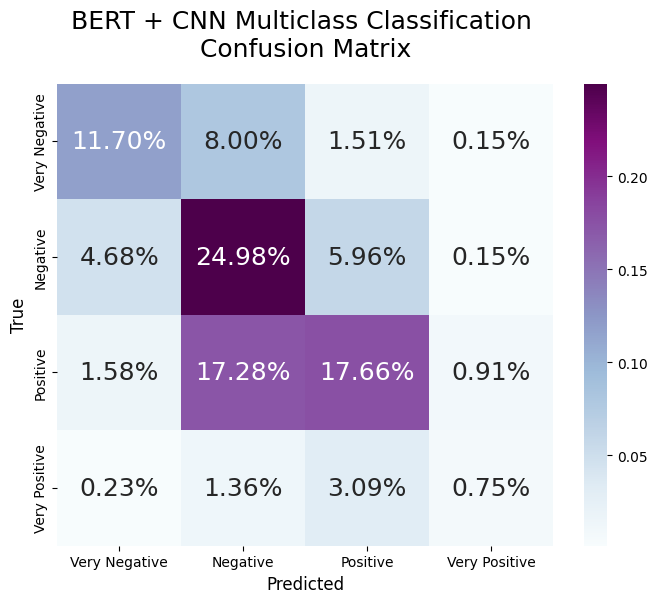

In [25]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# path_output_images = '/content/drive/MyDrive/NLP/Plots/'

# cm = confusion_matrix(y_test, y_pred)

# # Create a heatmap of the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
#             xticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive']
#             , yticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive'],
#             annot_kws={"size": 18})
# plt.xlabel('Predicted Label', size=12)
# plt.ylabel('True Label', size=12)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('BERT + CNN Multiclass Classification \nConfusion Matrix', size=18,
#              pad=20)
# plt.savefig(path_output_images + 'plot_CM_bert_Cnn_Multi.png', transparent=True)
# plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

path_output_images = '/content/drive/MyDrive/NLP/Plots/'

# Get predicted classes (integers) from probabilities using argmax
predicted_classes = np.argmax(y_pred, axis=1)

# Now use predicted_classes in confusion_matrix
cm = confusion_matrix(y_test, predicted_classes) # Changed from y_pred to predicted_classes

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive']
            , yticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT + CNN Multiclass Classification \nConfusion Matrix', size=18,
             pad=20)
plt.savefig(path_output_images + 'plot_CM_bert_Cnn_Multi.png', transparent=True)
plt.show()

In [26]:
# ... previous code ...

# Make predictions on the test set
y_pred = classification_model.predict(
    [X_test_tokens['input_ids'], X_test_tokens['token_type_ids'], X_test_tokens['attention_mask']]
)

# Get the predicted classes
predicted_classes = np.argmax(y_pred, axis=1) # Define predicted_classes here

# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': predicted_classes})

# ... rest of the code ...

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

42/42 [==============================] - 5s 121ms/step
True Positives:
                                                   text  true_label  \
4999  City Summons Reporter to Court After He Asked ...           1   
5923  With as little as seven weeks left, GOP races ...           1   
4379     Coinbase Lays Off Another 20% of its Employees           1   

      predicted_label  
4999                1  
5923                1  
4379                1  

True Negatives:
                                                   text  true_label  \
4240  Alabama mayor's apparent suicide underscores t...           0   
1488  Cody Dorman, who inspired a nation over his bo...           0   
6375  SCARY SCENE: Eagles star carted off field on s...           0   

      predicted_label  
4240                0  
1488                0  
6375                0  

False Positives:
                                                   text  true_label  \
1599  Opinion | Inside the far right's roadmap to in...      

,text,true_label,predicted_label
2945,GOP Presidential Debate Could Be an Embarrassi...,1,0
5497,Watchdog agency increases its pandemic unemplo...,1,0
585,All the prison's presidents: Peru's special ja...,1,0
